In [1]:
import pandas as pd
import numpy as np
import sklearn

#statistics
from scipy.stats import chi2_contingency, ttest_ind

import cudf #gpu-powered DataFrame (Pandas alternative)

#imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, RepeatedEditedNearestNeighbours
from imblearn.pipeline import Pipeline

#preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, MinMaxScaler

#internal validation
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, PredefinedSplit

#performance metrices
from sklearn.metrics import confusion_matrix, classification_report, f1_score, balanced_accuracy_score, matthews_corrcoef, auc, average_precision_score, roc_auc_score, balanced_accuracy_score, roc_curve, accuracy_score

#Models selection
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from cuml.svm import SVC #gpu-powered SVM

from scipy.stats import ttest_ind_from_stats

import seaborn as sn


#save and load trained model
import pickle

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter


In [2]:
# Data loader
features = pd.read_csv("../FinalData/cleaned_features_2vs1_15022024.csv", low_memory=False)
outcomes = pd.read_csv("../FinalData/cleaned_outcomes_2vs1_09122023.csv")
# features = features[features.columns[1:]]
# outcomes = outcomes[outcomes.columns[1:]]

In [3]:
masterData = features.merge(outcomes, how = 'left', left_on='patid', right_on='patid') #join table
# masterData = masterData.dropna() #NAs from Country
masterData = masterData.reset_index(drop=True)
exclude_columns = ['weight', 'height', 'id', 'event_date', 'recorded_date', 'visit_id', 'code_id', 'snomed_id',
       'numeric_1', 'numeric_2', 'created_datetime', 'updated_datetime',]
masterData = masterData.loc[:,~masterData.columns.isin(exclude_columns)]
print('original data shape: ', masterData.shape)

original data shape:  (633476, 96)


In [4]:
masterData = masterData[(masterData.age >= 8) & (masterData.age <= 80)]


In [5]:
masterData = masterData.drop_duplicates('patid')

In [6]:
masterData.shape

(633476, 96)

In [7]:
#transform IMD
def transform_imd(x):
    if x == 0:
        return 'unknown'
    elif (x >=1) & (x <=3):
        return '1-3'
    elif (x >=4) & (x <=7):
        return '4-7'
    elif (x >=8) & (x <=10):
        return '>7'
        
masterData['cat_imd_decile'] = masterData.apply(lambda x: transform_imd(x['imd_decile']), axis=1)

In [8]:
#Data scenario
# 1: all data without ethnicity variable
# 2: all data with ethnicity variable (include all missing values in ethnicity as separate group)
# 3: filter data based on ethnicity (exclude missing values)

scenario = 1 #change it based on the scenario

if scenario == 1:
    #include all data
    allData = masterData
    
elif scenario == 2:
    #Exclude ethnic column
    allData = masterData.drop('ethnic_group', axis=1)
    
elif scenario == 3:
    #exclude missing values for ethnic variable
    allData = masterData[masterData.ethnic_group!='not_recorded']
    
allData = allData.reset_index(drop=True)
print('Data shape for scenario', str(scenario), allData.shape)



Data shape for scenario 1 (633476, 97)


In [9]:
#Split data into training and evaluation set based on the country. Include only 18+ patients.

trainingData = allData[(allData.Country == 'England')]
evaluationData = allData[((allData.Country == 'Scotland') | (allData.Country == 'Wales'))] #used for validation
evaluationDataWales = allData[(allData.Country == 'Wales') ] #used for validation
evaluationDataScotland = allData[(allData.Country == 'Scotland')] #used for validation

#remove country variable
trainingData = trainingData.drop('Country', axis=1)
evaluationData = evaluationData.drop('Country', axis=1)
evaluationDataWales = evaluationDataWales.drop('Country', axis=1)
evaluationDataScotland = evaluationDataScotland.drop('Country', axis=1)

trainingData = trainingData.reset_index(drop=True)
evaluationData = evaluationData.reset_index(drop=True)
evaluationDataWales = evaluationDataWales.reset_index(drop=True)
evaluationDataScotland = evaluationDataScotland.reset_index(drop=True)

print('Training data shape:', trainingData.shape)
print('Evaluation data shape: ', evaluationData.shape)
print('Evaluation data Wales shape: ', evaluationDataWales.shape)
print('Evaluation data Scotland shape: ', evaluationDataScotland.shape)

Training data shape: (609593, 96)
Evaluation data shape:  (23883, 96)
Evaluation data Wales shape:  (15272, 96)
Evaluation data Scotland shape:  (8611, 96)


In [10]:
trainingData.columns

Index(['patid', 'practice_id', 'sex', 'age', 'BMI', 'ethnicity',
       'ethnic_group', 'smokingStatus', 'CharlsonScore', 'count_rhinitis',
       'count_cardiovascular', 'count_heartfailure', 'count_psoriasis',
       'count_anaphylaxis', 'count_diabetes', 'count_ihd', 'count_anxiety',
       'count_eczema', 'count_nasalpolyps', 'count_paracetamol',
       'count_nsaids', 'count_betablocker', 'PEFStatus', 'EosinophilLevel',
       'BTS_step', 'average_daily_dose_ICS', 'prescribed_daily_dose_ICS',
       'ICS_medication_possesion_ratio', 'DeviceType', 'Spacer', 'numOCS',
       'PriorEducation', 'numPCS', 'numPCSAsthma', 'numAntibioticsEvents',
       'numAntibioticswithLRTI', 'numOCSEvents', 'numOCSwithLRTI',
       'numAsthmaAttacks', 'numAcuteRespEvents', 'numHospEvents', 'month_12',
       'month_1', 'month_3', 'month_4', 'month_5', 'month_7', 'month_10',
       'month_6', 'month_11', 'month_9', 'month_2', 'month_8',
       'postcode_district', 'imd_decile', 'County', 'LocalAuthori

In [13]:
cat_vars = ['sex', 'cat_age', 'cat_BMI', 'ethnic_group', 'smokingStatus', 'system', 'CharlsonScore', 'rhinitis',
       'cardiovascular', 'heartfailure', 'psoriasis',
       'anaphylaxis', 'diabetes', 'ihd', 'anxiety',
       'eczema', 'nasalpolyps', 'paracetamol',
       'nsaids', 'betablocker', 'PEFStatus', 'EosinophilLevel',
       'BTS_step', 'DeviceType', 'cat_imd_decile',  
       'cat_average_daily_dose_ICS', 'cat_prescribed_daily_dose_ICS',
       'cat_ICS_medication_possesion_ratio', 'cat_numOCS', 'cat_numOCSEvents',
       'cat_numOCSwithLRTI', 'cat_numAcuteRespEvents',
       'cat_numAntibioticsEvents', 'cat_numAntibioticswithLRTI',
       'cat_numAsthmaAttacks', 'cat_numHospEvents', 'cat_numPCS',
       'cat_numPCSAsthma']

cont_vars = ['age', 'average_daily_dose_ICS', 'prescribed_daily_dose_ICS',
       'ICS_medication_possesion_ratio', 'numOCS',
       'numPCS', 'numPCSAsthma', 'numAntibioticsEvents',
       'numAntibioticswithLRTI', 'numOCSEvents', 'numOCSwithLRTI',
       'numAsthmaAttacks', 'numAcuteRespEvents', 'numHospEvents']

In [12]:
trainingData['set'] = 'training'
evaluationData['set'] = 'eval'
evaluationDataWales['set'] = 'Wales'
evaluationDataScotland['set'] = 'Scotland'

In [40]:
outcome = '12MonthsOutcome'
trainingData.groupby(outcome).sex.first()

12MonthsOutcome
0    0.0
1    0.0
Name: sex, dtype: float64

In [83]:
chi2_contingency(trainingData.pivot_table('patid', outcome, 'ethnic_group', 'count'))

Chi2ContingencyResult(statistic=865.0259445373904, pvalue=9.859856738931799e-185, dof=5, expected_freq=array([[1.16204366e+04, 5.68712231e+03, 1.95100503e+03, 2.60539912e+04,
        1.36712420e+05, 3.55885025e+05],
       [1.54856343e+03, 7.57877691e+02, 2.59994969e+02, 3.47200880e+03,
        1.82185801e+04, 4.74259751e+04]]))

In [88]:
from scipy.stats import chi2_contingency, fisher_exact
tab = trainingData.pivot_table(values='patid', index=outcome, columns='sex', aggfunc='count', fill_value=0)
chi2_contingency(tab)

Chi2ContingencyResult(statistic=2172.017947365352, pvalue=0.0, dof=2, expected_freq=array([[3.09166793e+05, 2.28713205e+05, 3.00018865e+01],
       [4.12002068e+04, 3.04787951e+04, 3.99811350e+00]]))

variable:  sex
sex                 0.0     1.0  2.0
12MonthsOutcome                     
0                303376  234500   34
1                 46991   24692    0
pvalue:  0.0


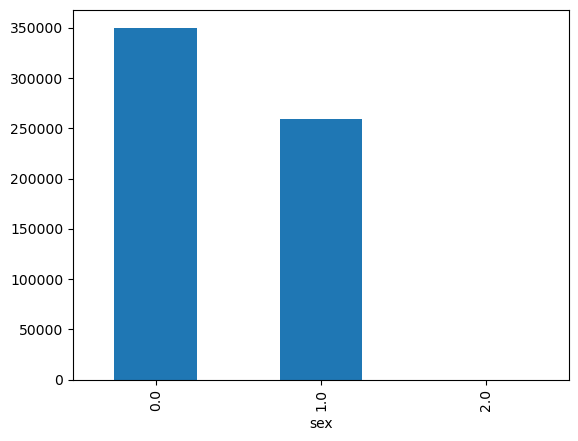

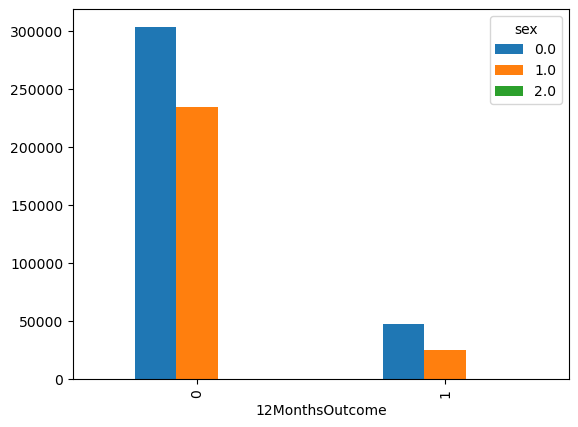

variable:  cat_age
cat_age           18-34   35-54   55-74    <18   >=75
12MonthsOutcome                                      
0                135034  166799  136619  75211  24247
1                 12773   23422   25076   5124   5288
pvalue:  0.0


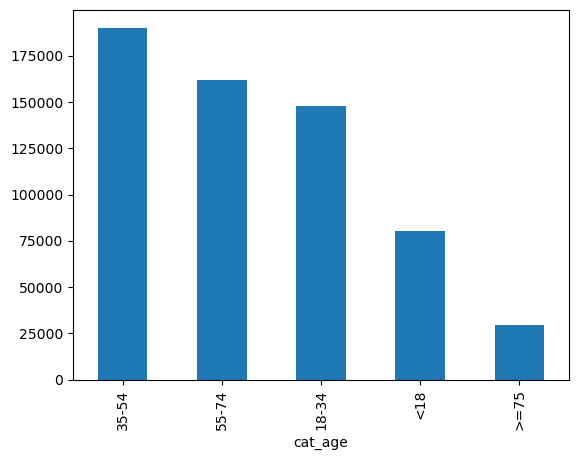

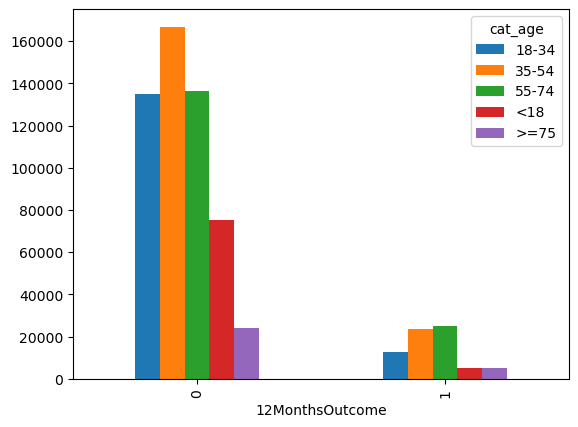

variable:  cat_BMI
cat_BMI          normal  not recorded   obese  overweight  underweight
12MonthsOutcome                                                       
0                169094         41506  146429      150437        30444
1                 18193          2472   27840       20610         2568
pvalue:  0.0


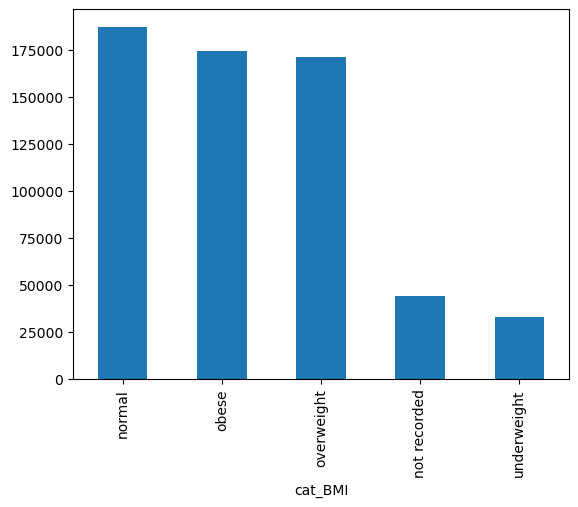

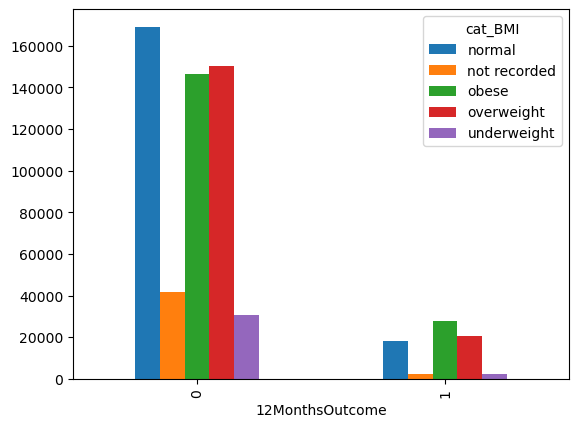

variable:  ethnic_group
ethnic_group     Asian - ethnic group  Black - ethnic group  \
12MonthsOutcome                                               
0                               11323                  5836   
1                                1846                   609   

ethnic_group     Mixed ethnic census group  Other ethnic group  \
12MonthsOutcome                                                  
0                                     2003               25057   
1                                      208                4469   

ethnic_group     White - ethnic group  not_recorded  
12MonthsOutcome                                      
0                              134833        358858  
1                               20098         44453  
pvalue:  9.859856738931799e-185


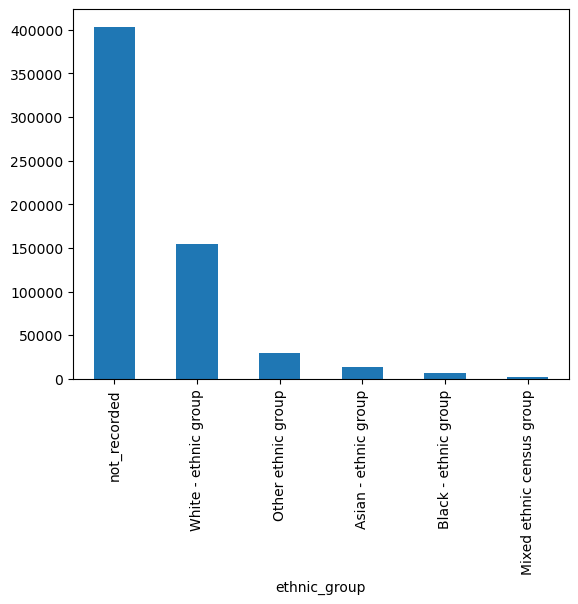

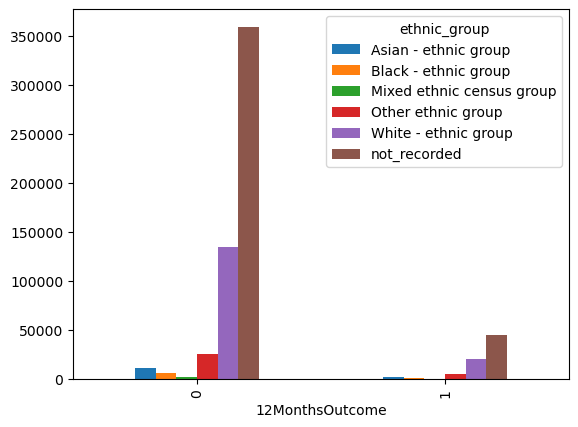

variable:  smokingStatus
smokingStatus    Active Smoker  Former Smoker  Non Smoker
12MonthsOutcome                                          
0                       124602         128059      285249
1                        22692          19978       29013
pvalue:  0.0


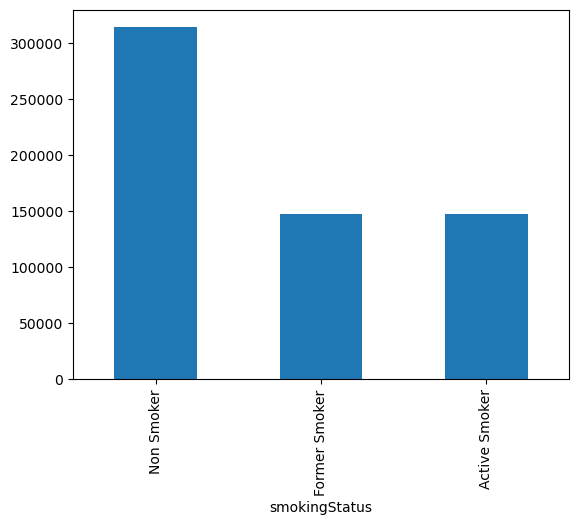

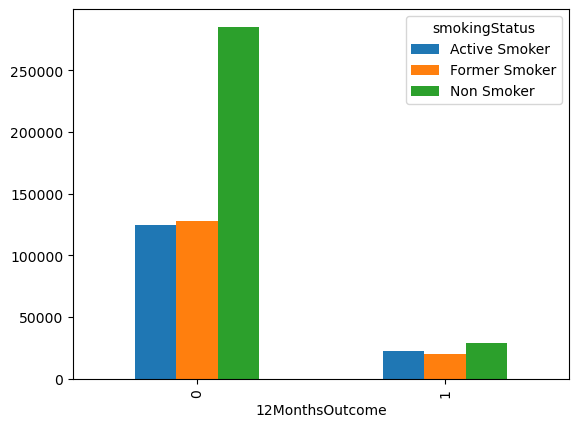

variable:  system
system             EMIS  SystemOne  Vision
12MonthsOutcome                           
0                283961     248511    5438
1                 31881      39149     653
pvalue:  0.0


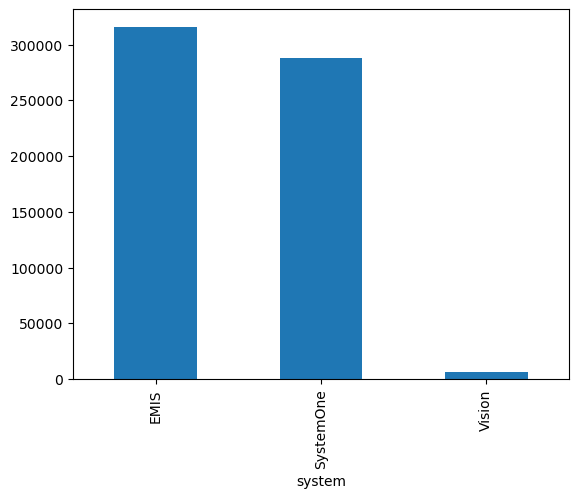

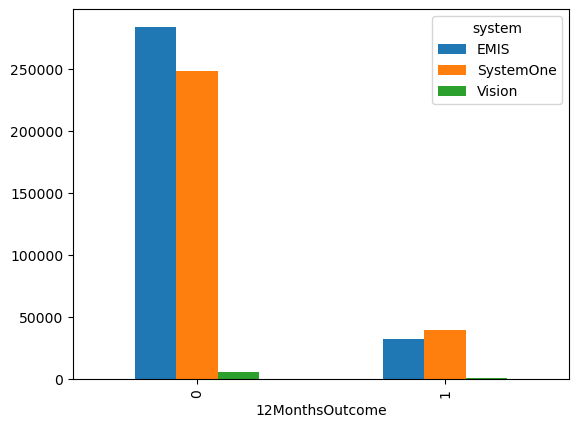

variable:  CharlsonScore
CharlsonScore     0.0     1.0    2.0    3.0    4.0   5.0   6.0   7.0   8.0   \
12MonthsOutcome                                                               
0                31661  411903  51955  23752  12511  3347  1514   817   272   
1                 3025   49770  10255   4587   2616   785   393   177    51   

CharlsonScore    9.0   10.0  11.0  12.0  13.0  14.0  15.0  
12MonthsOutcome                                            
0                  96    55    19     5     1     1     1  
1                  13     6     3     1     1     0     0  
pvalue:  0.0


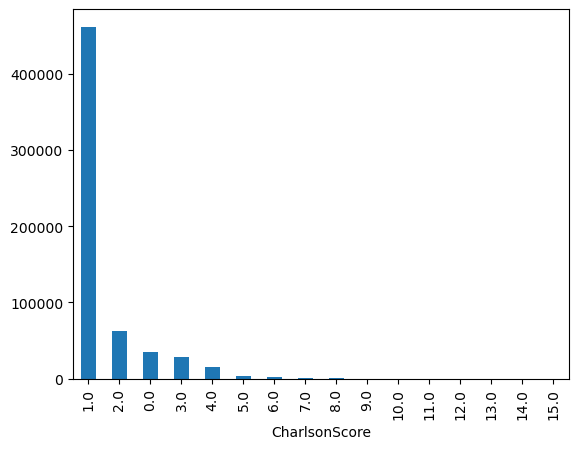

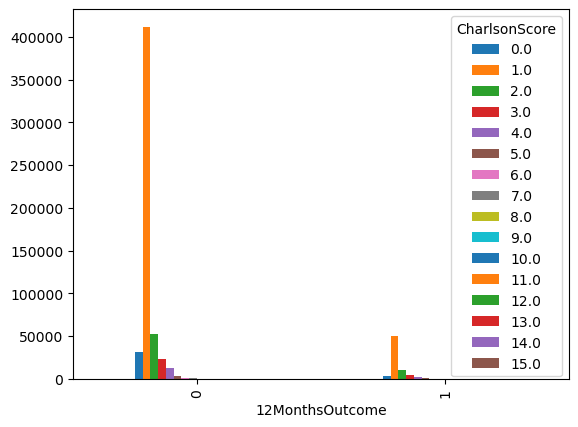

variable:  rhinitis
rhinitis              0       1
12MonthsOutcome                
0                372976  164934
1                 48694   22989
pvalue:  1.772674658459069e-14


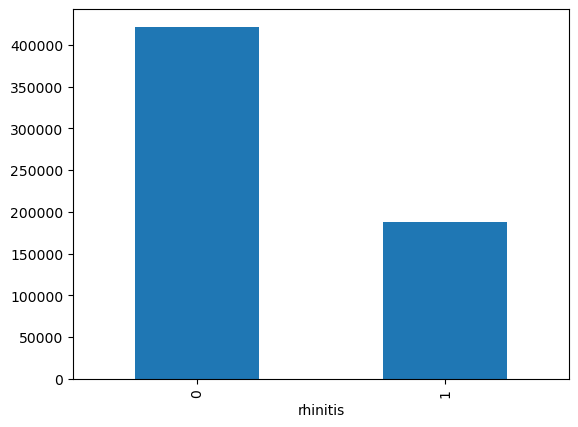

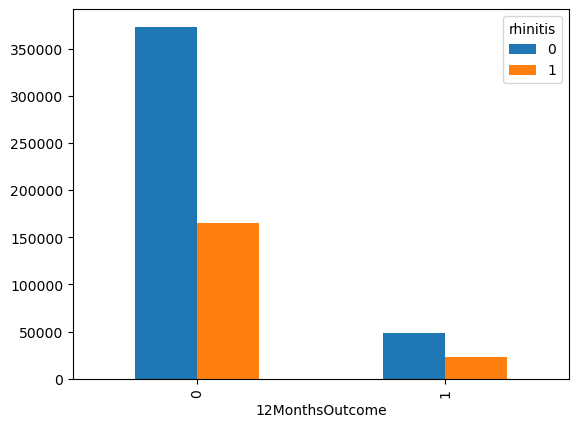

variable:  cardiovascular
cardiovascular        0       1
12MonthsOutcome                
0                320407  217503
1                 37503   34180
pvalue:  6.136481401774688e-300


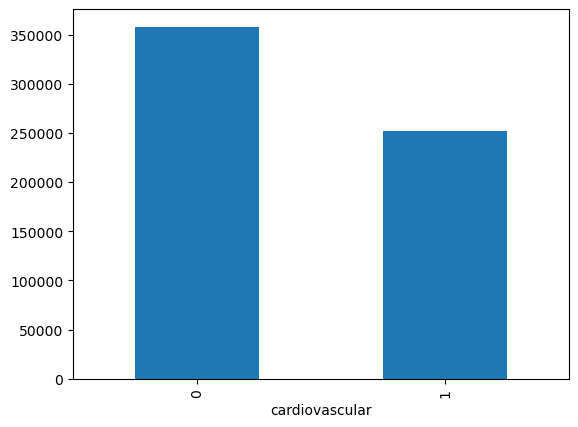

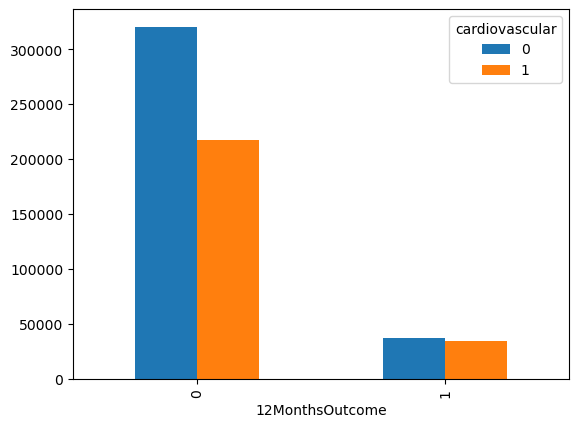

variable:  heartfailure
heartfailure          0      1
12MonthsOutcome               
0                516551  21359
1                 70034   1649
pvalue:  1.3878276809436785e-107


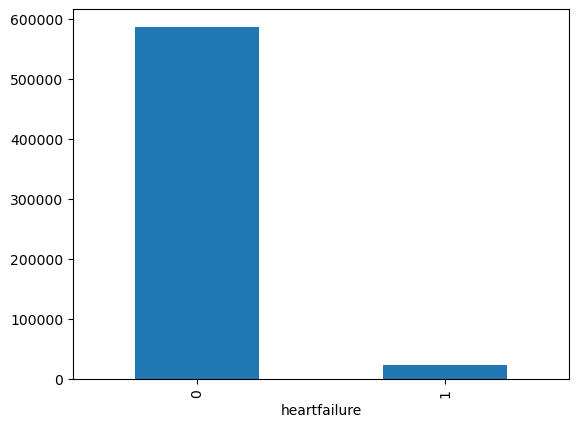

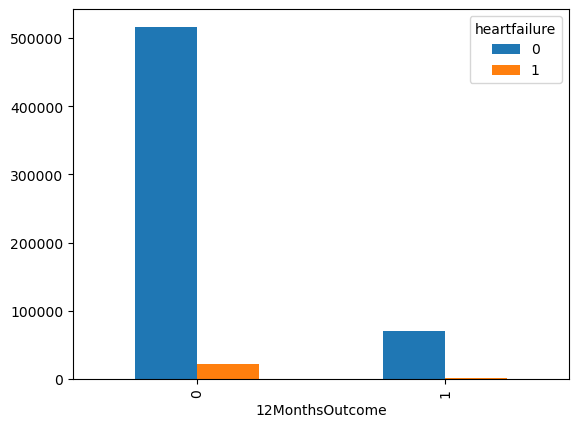

variable:  psoriasis
psoriasis             0      1
12MonthsOutcome               
0                501774  36136
1                 67984   3699
pvalue:  1.5600075978535691e-56


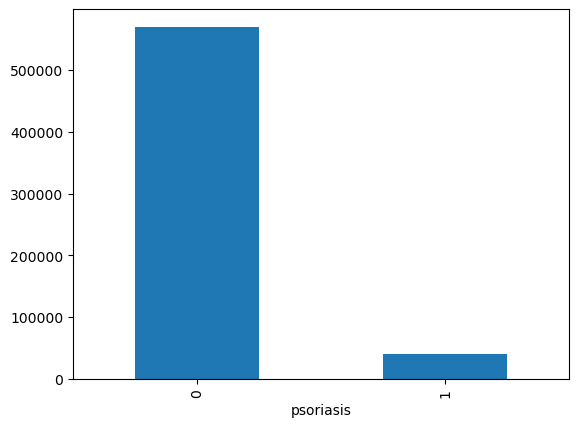

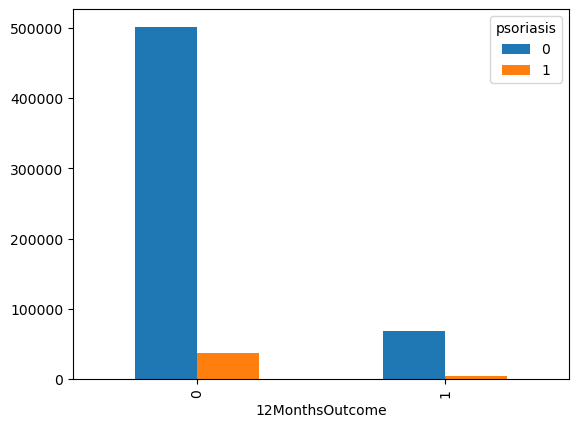

variable:  anaphylaxis
anaphylaxis           0      1
12MonthsOutcome               
0                519147  18763
1                 71022    661
pvalue:  2.211332436841383e-295


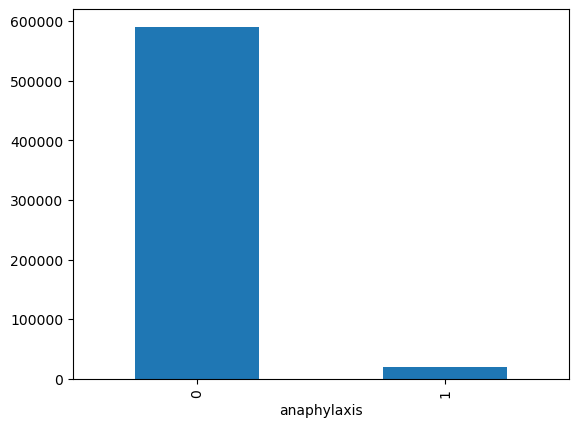

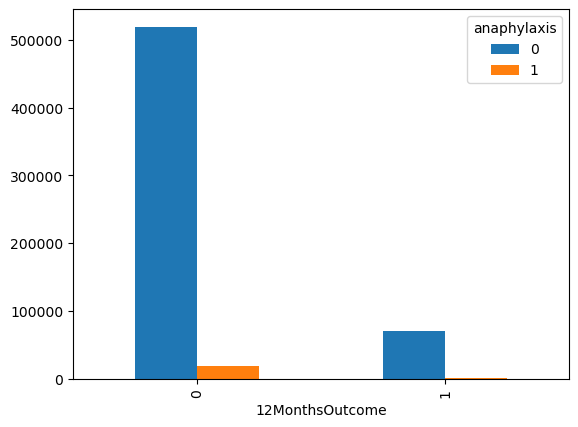

variable:  diabetes
diabetes              0      1
12MonthsOutcome               
0                455511  82399
1                 58599  13084
pvalue:  1.3207812469718963e-91


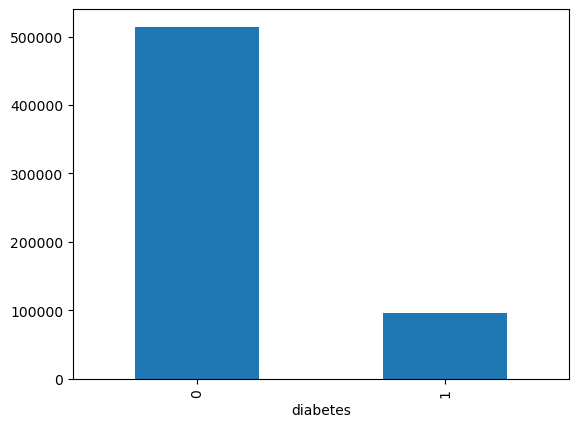

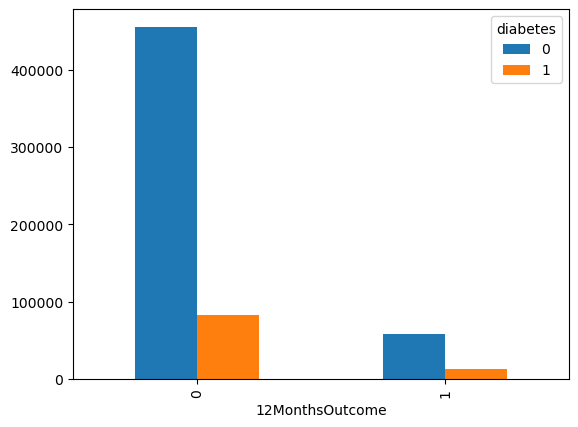

variable:  ihd
ihd                   0      1
12MonthsOutcome               
0                451685  86225
1                 57658  14025
pvalue:  4.143983272073983e-127


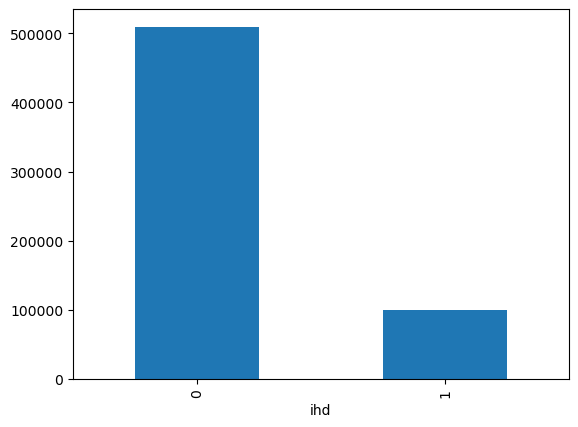

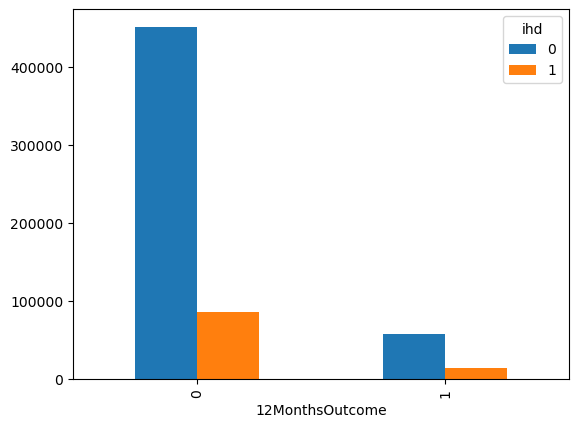

variable:  anxiety
anxiety               0       1
12MonthsOutcome                
0                405867  132043
1                 50089   21594
pvalue:  6.979772413641009e-229


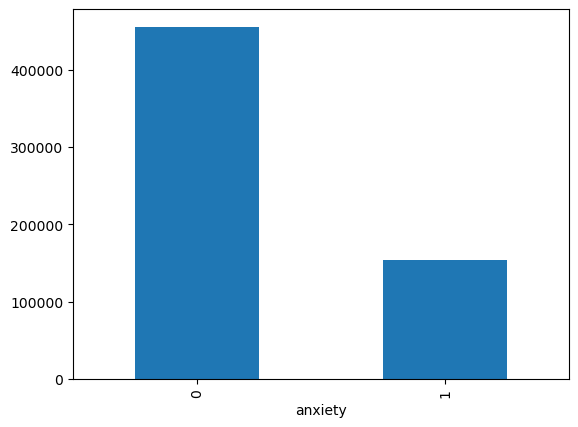

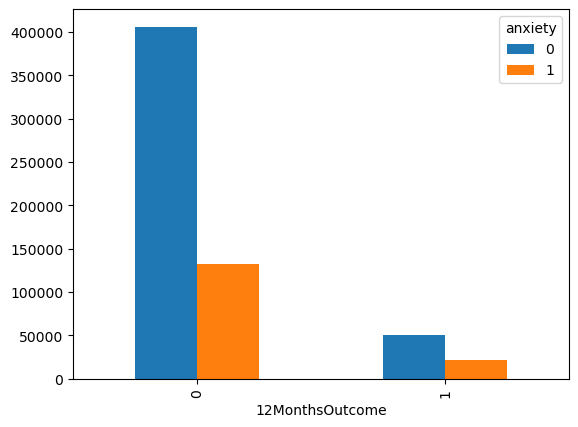

variable:  eczema
eczema                0       1
12MonthsOutcome                
0                372711  165199
1                 50446   21237
pvalue:  3.2572990512004256e-09


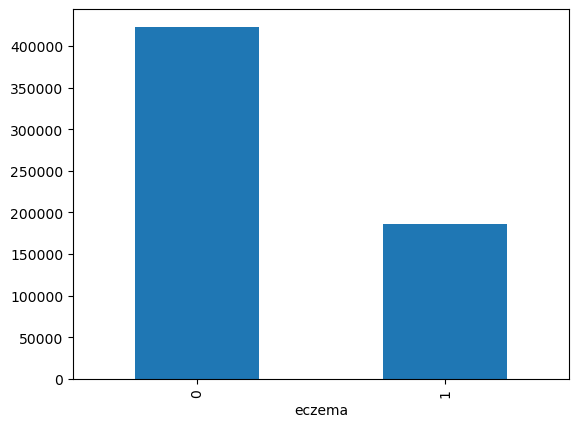

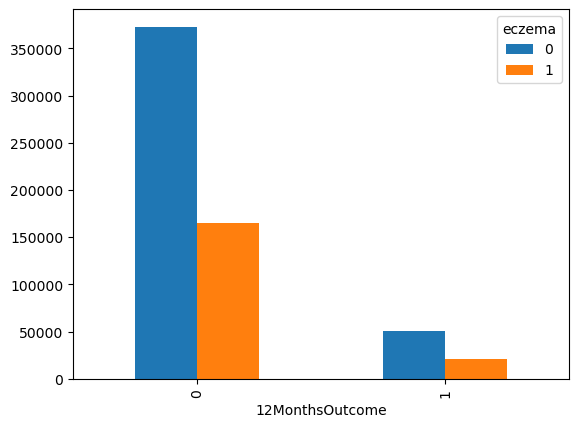

variable:  nasalpolyps
nasalpolyps           0      1
12MonthsOutcome               
0                506855  31055
1                 68359   3324
pvalue:  3.414956114907858e-35


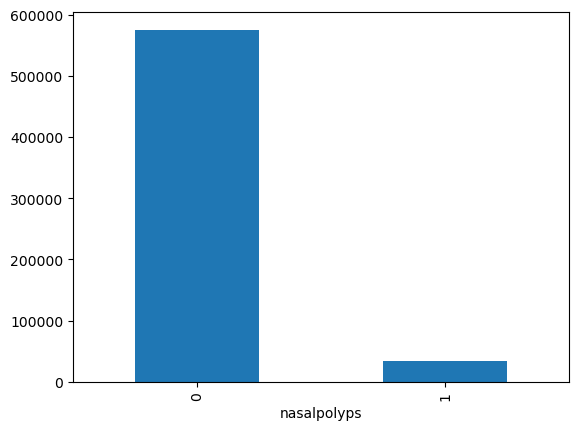

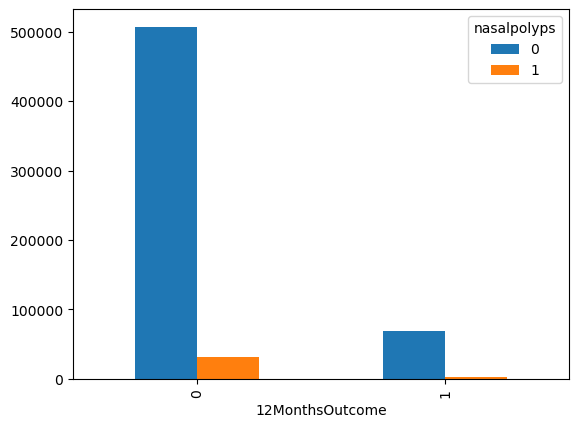

variable:  paracetamol
paracetamol           0      1
12MonthsOutcome               
0                521338  16572
1                 71454    229
pvalue:  0.0


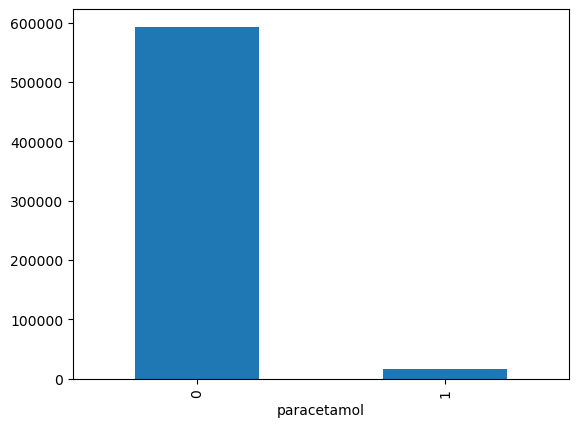

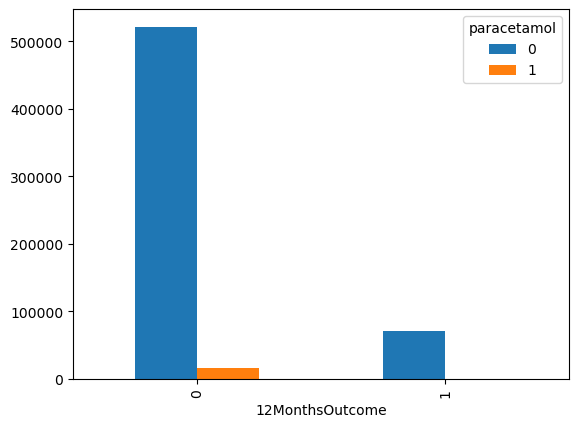

variable:  nsaids
nsaids                0      1
12MonthsOutcome               
0                521332  16578
1                 71466    217
pvalue:  0.0


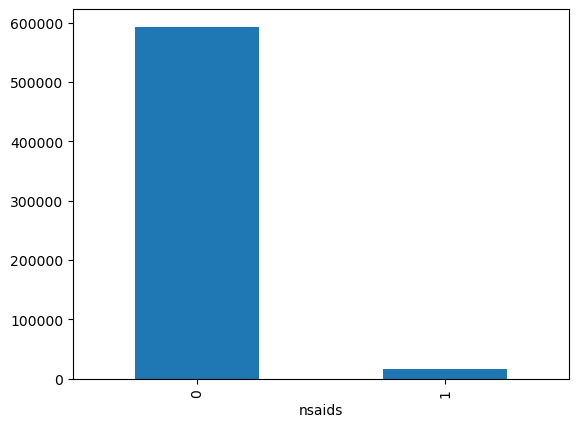

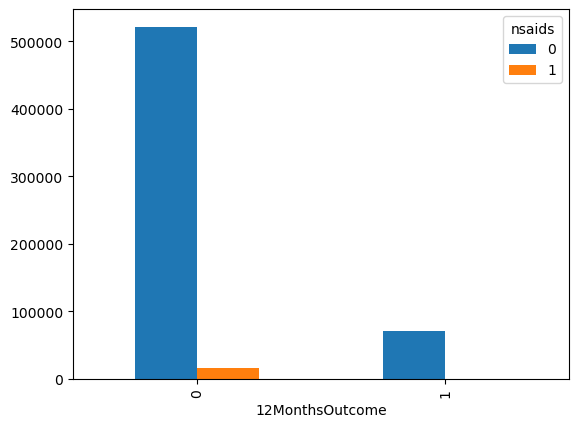

variable:  betablocker
betablocker           0      1
12MonthsOutcome               
0                521133  16777
1                 71395    288
pvalue:  0.0


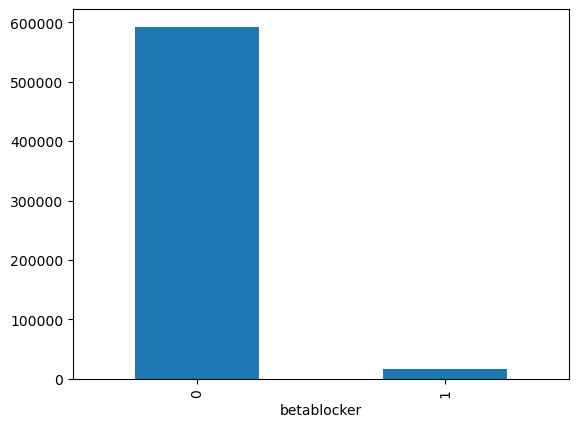

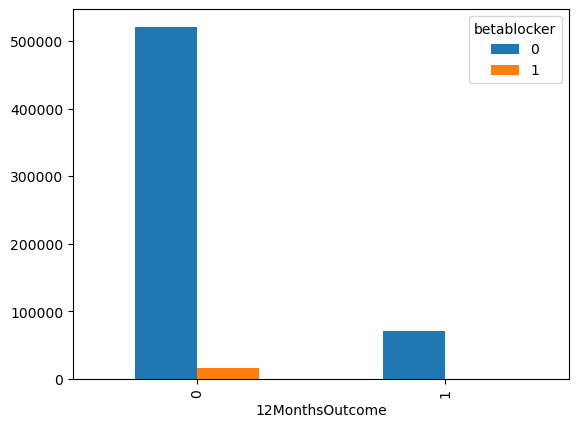

variable:  PEFStatus
PEFStatus        60-80  less than 60  more than 80  not_recorded
12MonthsOutcome                                                 
0                 5753          1359         12796        518002
1                 1068           334          1653         68628
pvalue:  1.294498203331367e-44


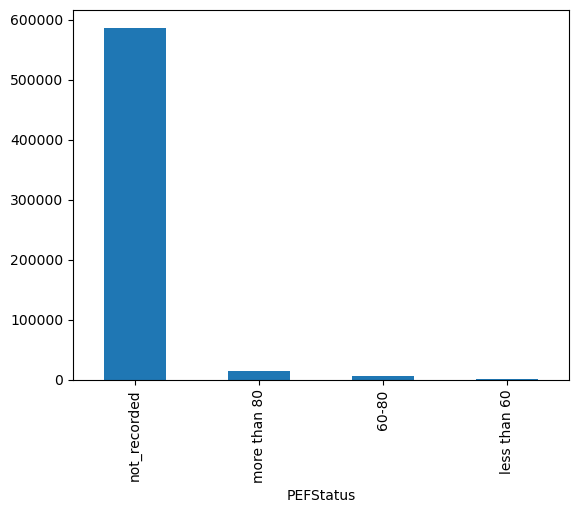

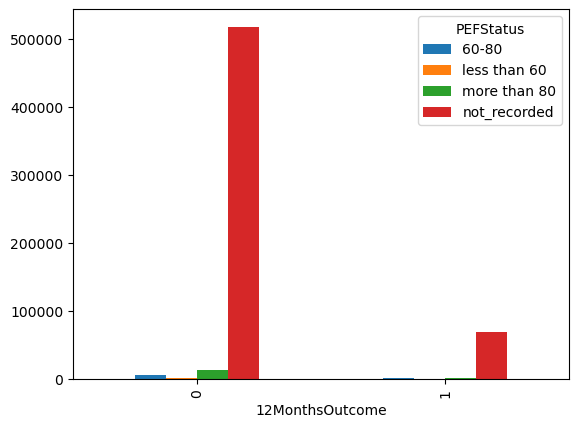

variable:  EosinophilLevel
EosinophilLevel   high  normal  unknown
12MonthsOutcome                        
0                65930  333723   138257
1                11032   51347     9304
pvalue:  0.0


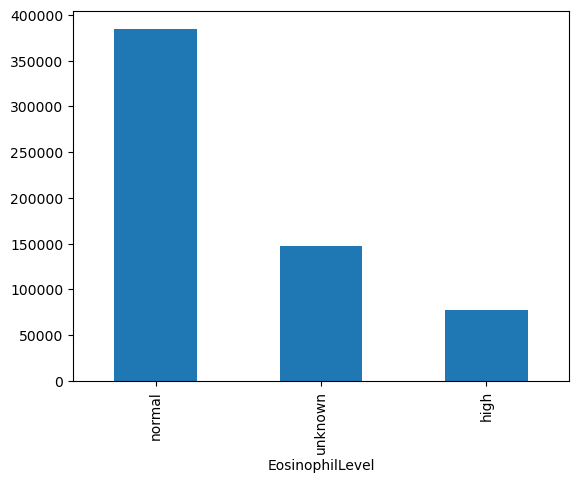

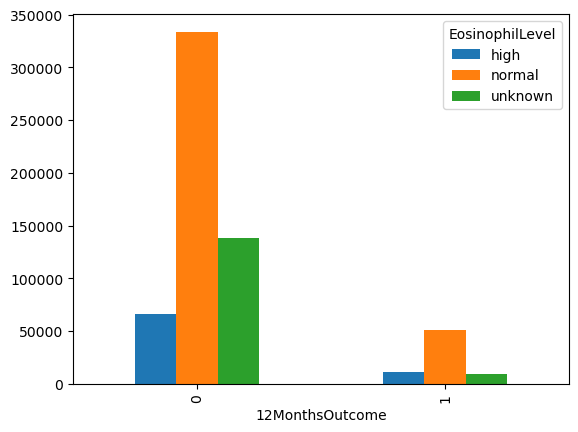

variable:  BTS_step
BTS_step            0.0    1.0    2.0    3.0    4.0    5.0
12MonthsOutcome                                           
0                360263  72776  12584  62688  10245  19354
1                 32492   5312   1426  10681   3071  18701
pvalue:  0.0


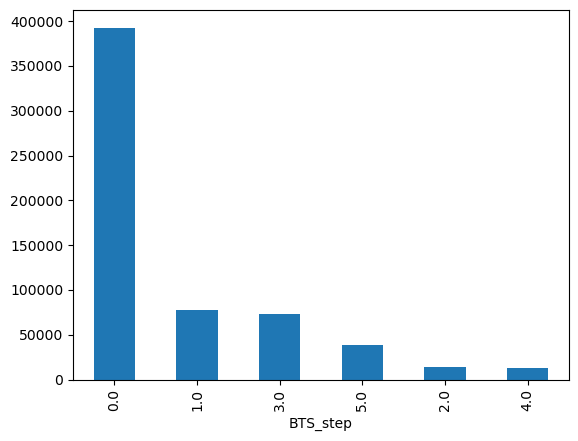

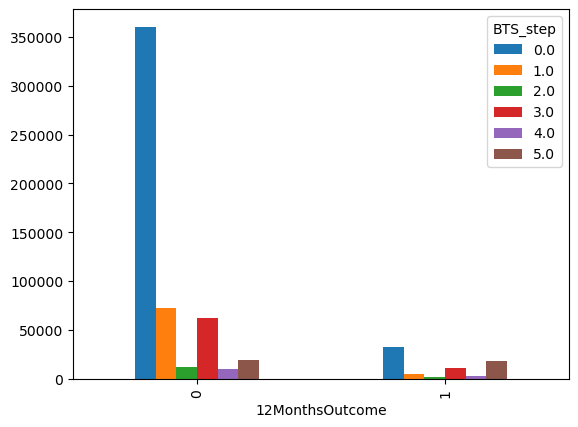

variable:  DeviceType
DeviceType        BAI    DPI  NEB    pMDI  unknown
12MonthsOutcome                                   
0                2711  72478  140  220875   241706
1                 304  17962  134   35308    17975
pvalue:  0.0


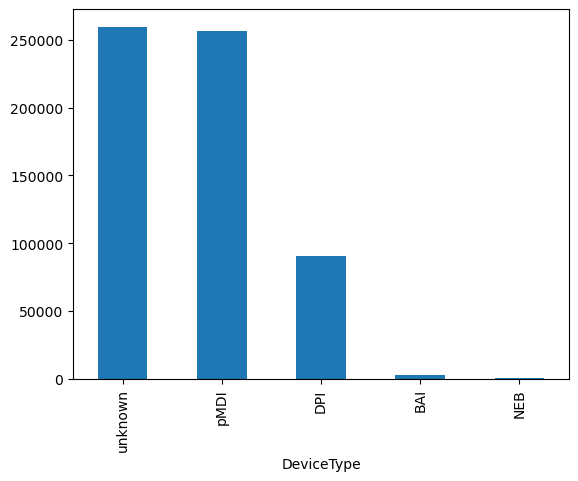

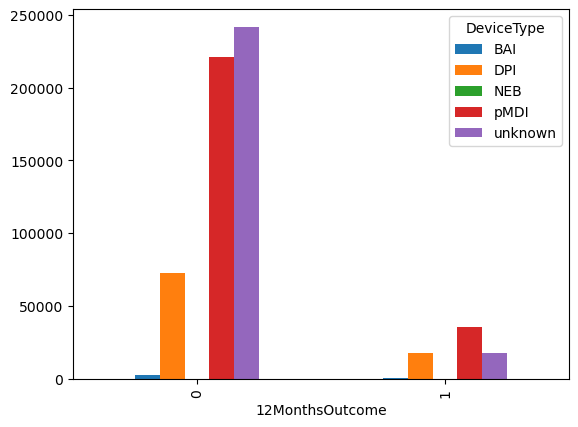

variable:  cat_imd_decile
cat_imd_decile      1-3     4-7      >7  unknown
12MonthsOutcome                                 
0                188050  200411  132835    16614
1                 27779   27522   14842     1540
pvalue:  6.132579301529797e-191


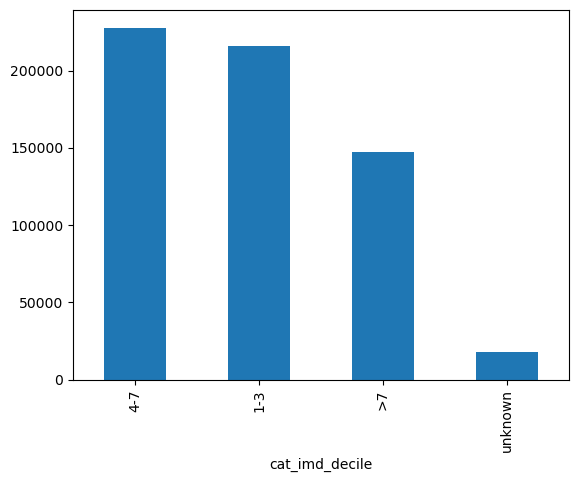

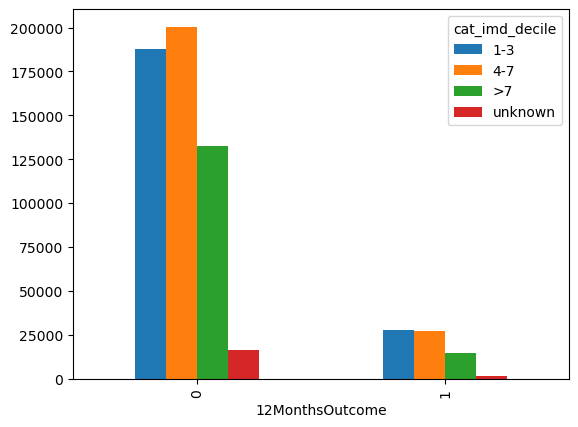

variable:  cat_average_daily_dose_ICS
cat_average_daily_dose_ICS       0  1-200  201-400   >400
12MonthsOutcome                                          
0                           241720  69422   140508  86260
1                            17976   7534    21302  24871
pvalue:  0.0


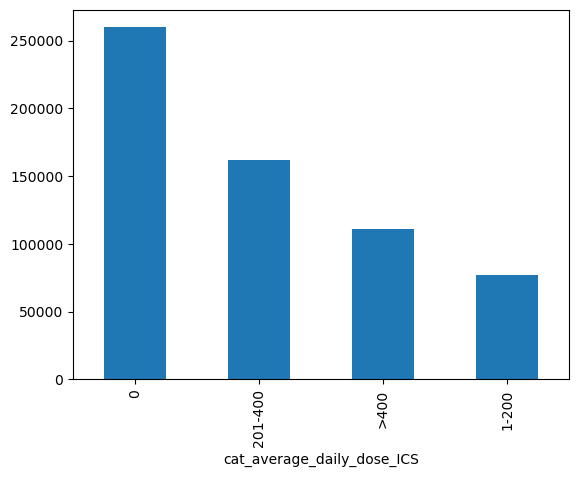

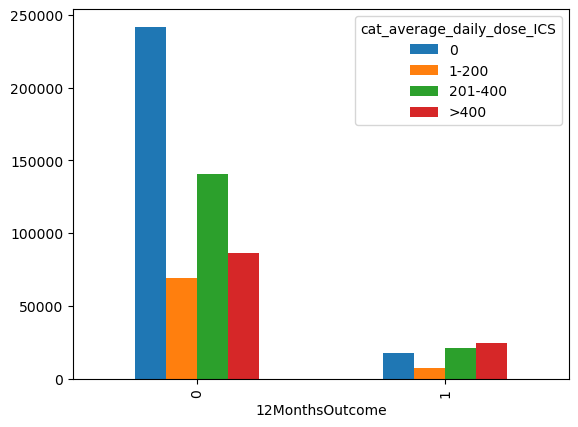

variable:  cat_prescribed_daily_dose_ICS
cat_prescribed_daily_dose_ICS       0  1-200  201-400   >400
12MonthsOutcome                                             
0                              241717  80271   139169  76753
1                               17976  10105    22254  21348
pvalue:  0.0


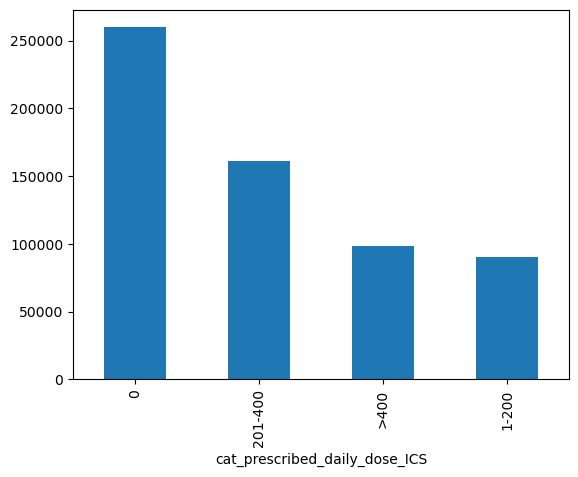

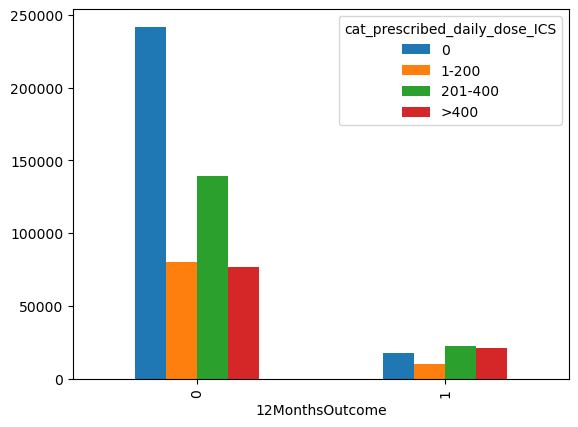

variable:  cat_ICS_medication_possesion_ratio
cat_ICS_medication_possesion_ratio  40%-59.9%  >0%-39.9%  No ICS Prescribed
12MonthsOutcome                                                            
0                                         354     295699             241857
1                                          29      53544              18110
pvalue:  0.0


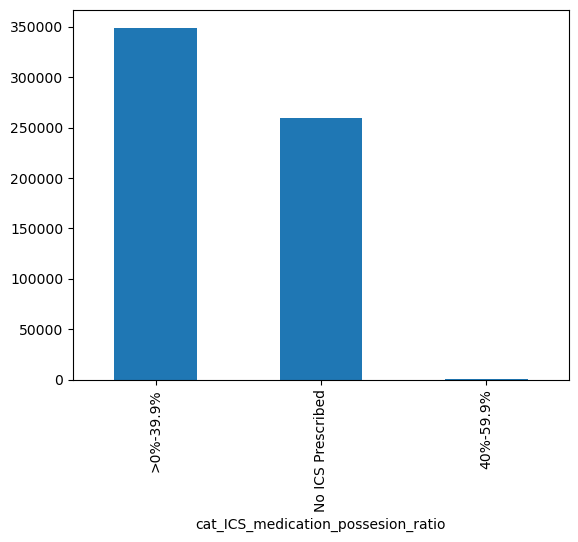

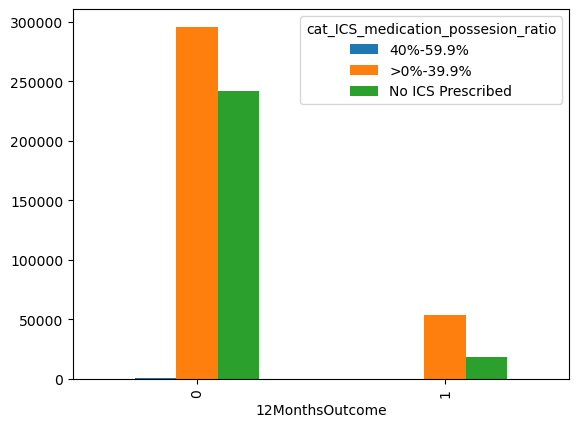

variable:  cat_numOCS
cat_numOCS            0      1      2    >=3
12MonthsOutcome                             
0                444674  52706  19444  21086
1                 32451  11654   7408  20170
pvalue:  0.0


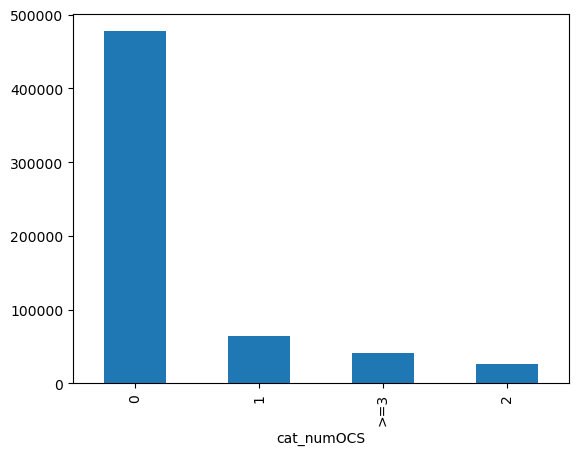

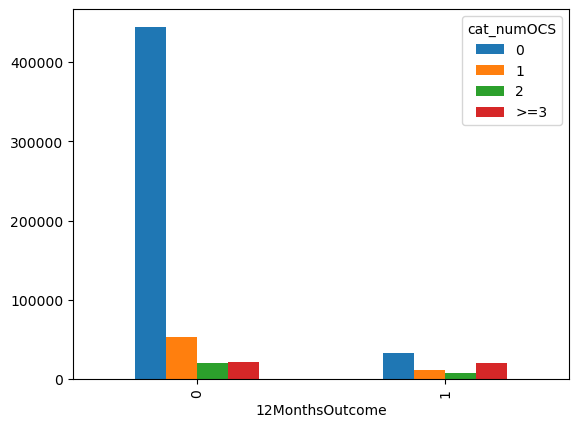

variable:  cat_numOCSEvents
cat_numOCSEvents       0      1      2    >=3
12MonthsOutcome                              
0                 444674  52706  19444  21086
1                  32451  11654   7408  20170
pvalue:  0.0


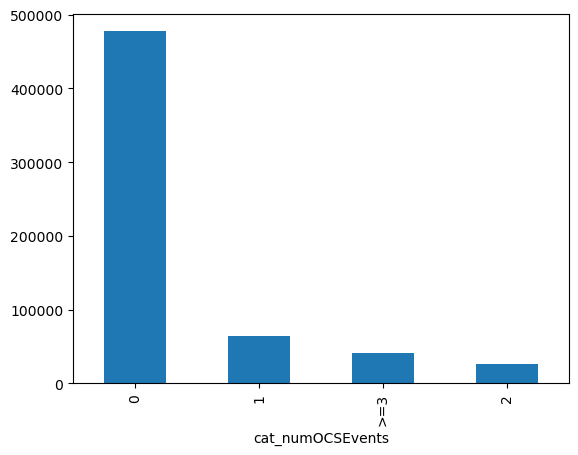

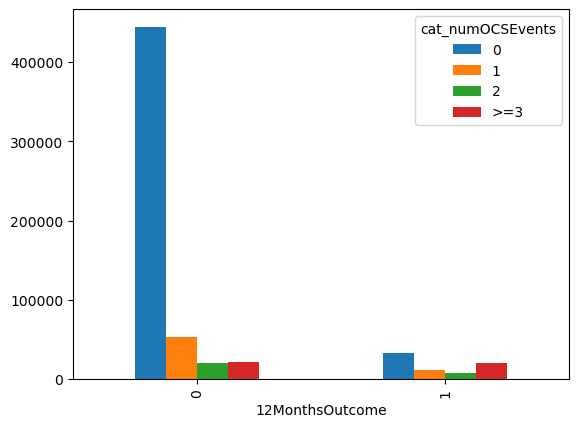

variable:  cat_numOCSwithLRTI
cat_numOCSwithLRTI       0      1      2    >=3
12MonthsOutcome                                
0                   470589  43635  13889   9797
1                    38397  12451   7495  13340
pvalue:  0.0


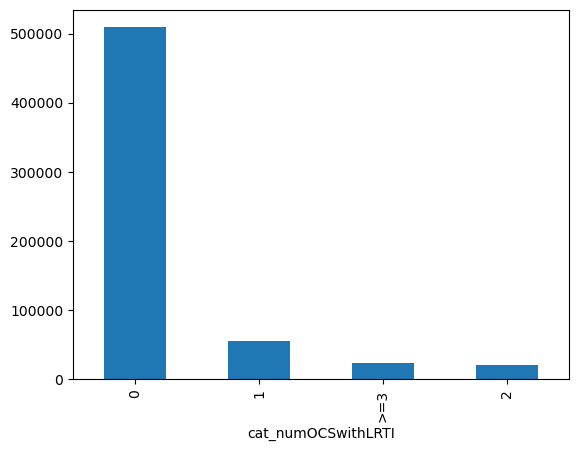

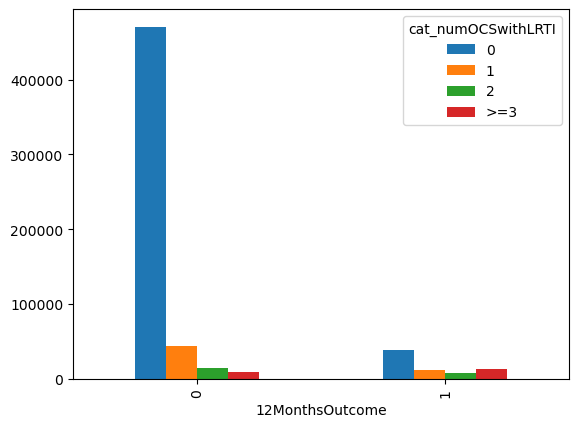

variable:  cat_numAcuteRespEvents
cat_numAcuteRespEvents       0     1    2  >=3
12MonthsOutcome                               
0                       535817  1099  446  548
1                        70962   194  141  386
pvalue:  4.4302815334862745e-192


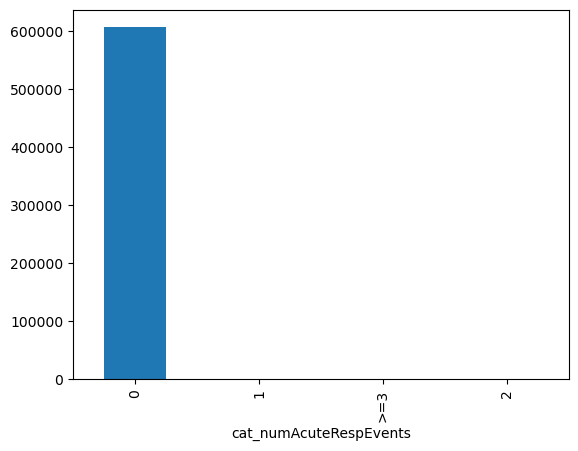

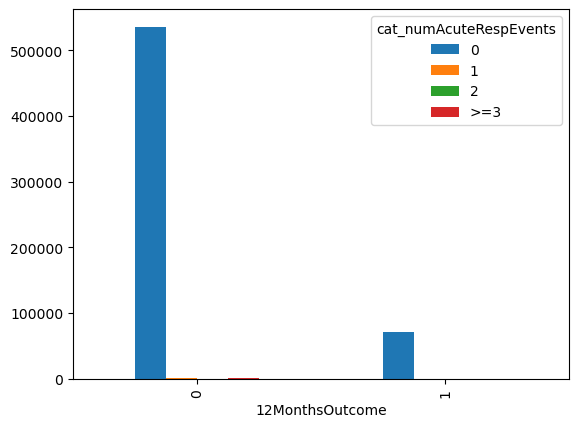

variable:  cat_numAntibioticsEvents
cat_numAntibioticsEvents       0      1      2    >=3
12MonthsOutcome                                      
0                         350673  82952  42680  61605
1                          24571  11777   8638  26697
pvalue:  0.0


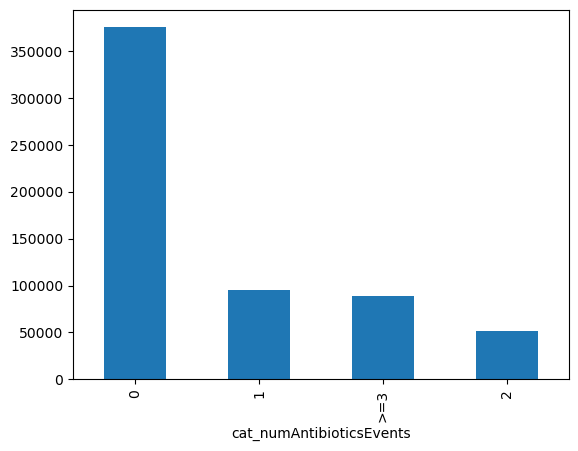

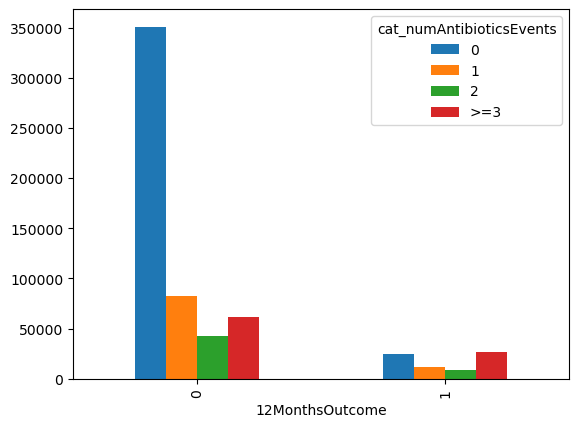

variable:  cat_numAntibioticswithLRTI
cat_numAntibioticswithLRTI       0      1      2    >=3
12MonthsOutcome                                        
0                           435332  61471  22591  18516
1                            35591  13161   8060  14871
pvalue:  0.0


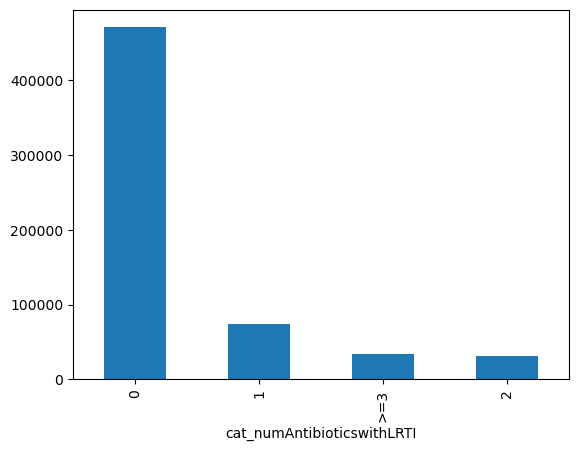

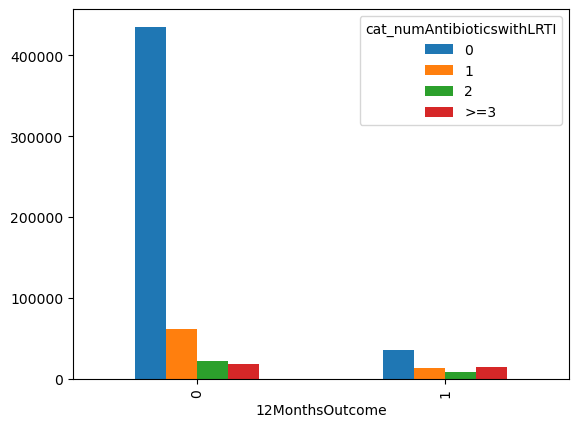

variable:  cat_numAsthmaAttacks
cat_numAsthmaAttacks       0      1      2    >=3
12MonthsOutcome                                  
0                     453179  54814  17313  12604
1                      34672  13692   8236  15083
pvalue:  0.0


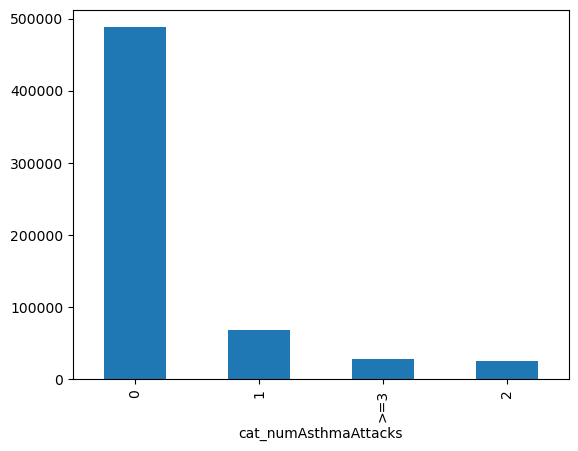

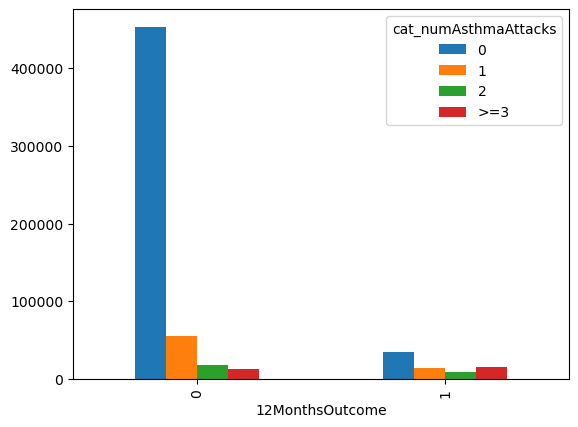

variable:  cat_numHospEvents
cat_numHospEvents       0     1    2  >=3
12MonthsOutcome                          
0                  532837  4743  301   29
1                   69802  1628  182   71
pvalue:  0.0


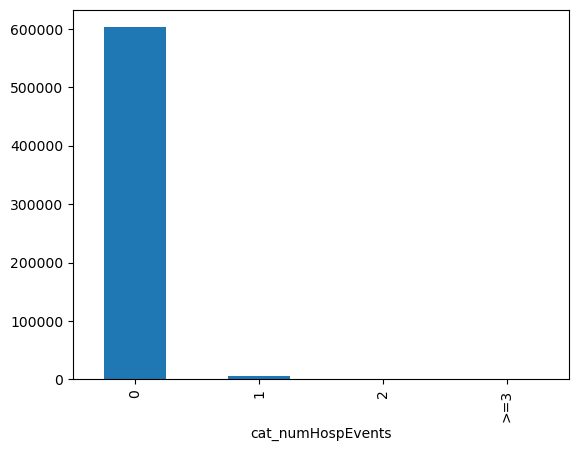

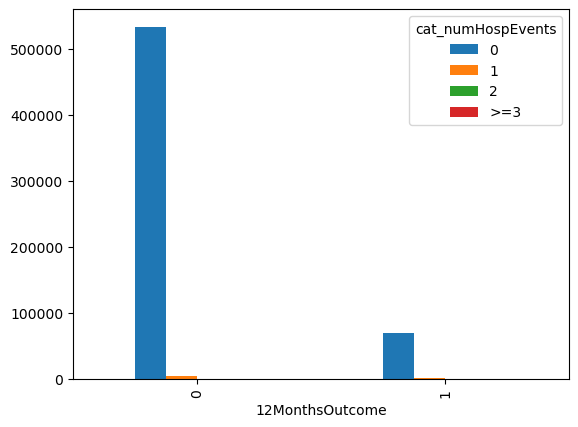

variable:  cat_numPCS
cat_numPCS           0     1     2     >=3
12MonthsOutcome                           
0                18123  2868  3515  513404
1                  395   190   216   70882
pvalue:  0.0


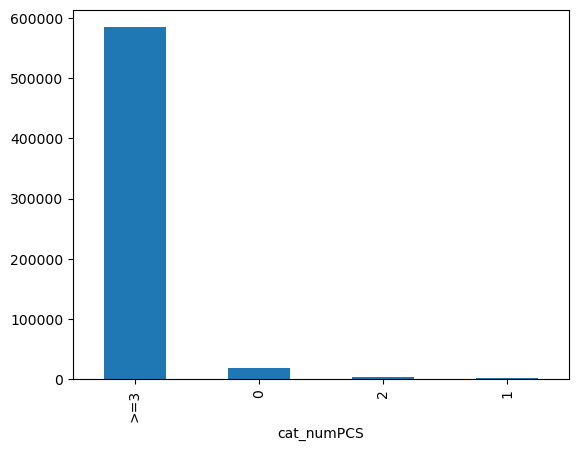

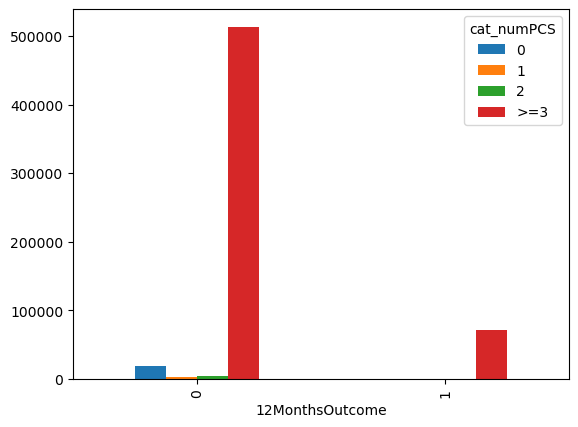

variable:  cat_numPCSAsthma
cat_numPCSAsthma      0       1       2    >=3
12MonthsOutcome                               
0                 88947  231533  138663  78767
1                 13409   22558   18391  17325
pvalue:  0.0


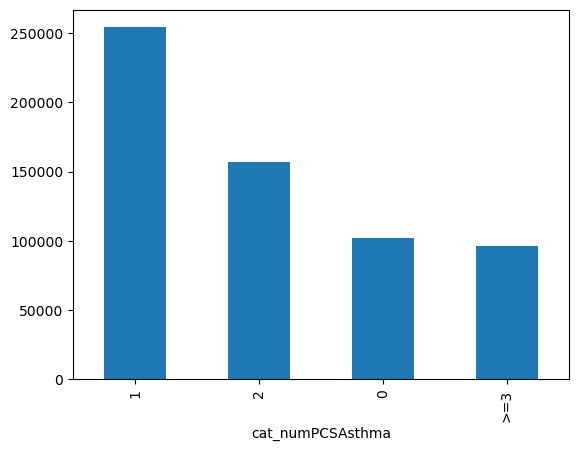

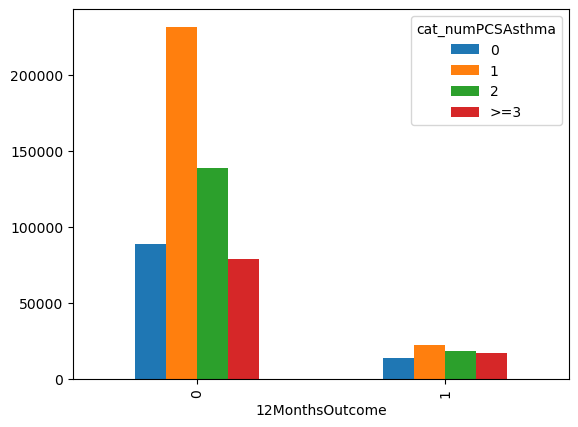

In [93]:
#Explore categorical
outcome = '12MonthsOutcome'

for var in cat_vars:
    print('variable: ', var)
    #visualisation in barplot
    trainingData.value_counts(var).plot(kind='bar')

    #cross table VAR x Outcome
    tab = pd.pivot_table(trainingData, values='patid', index=outcome, columns=var, aggfunc='count', fill_value=0)
    print(tab)
    print('pvalue: ', chi2_contingency(tab)[1])
    tab.plot(kind='bar')
    plt.show()

variable:  age
pvalue:  0.0


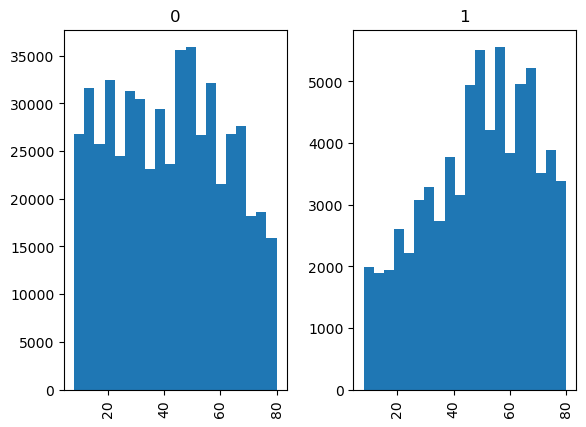

variable:  average_daily_dose_ICS
pvalue:  0.0


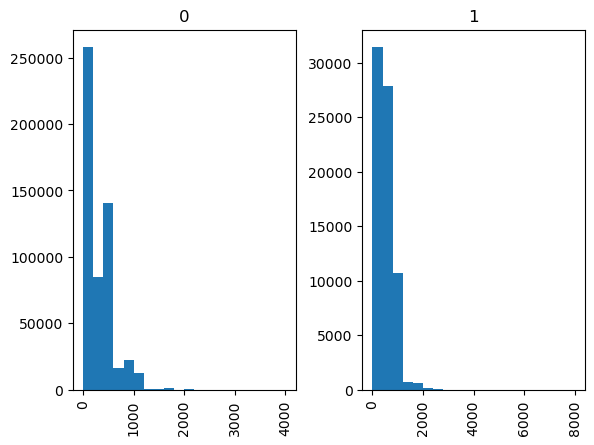

variable:  prescribed_daily_dose_ICS
pvalue:  0.0


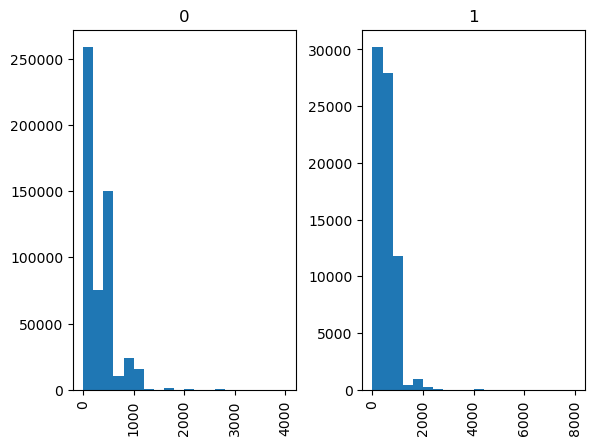

variable:  ICS_medication_possesion_ratio
pvalue:  2.9685076144812664e-272


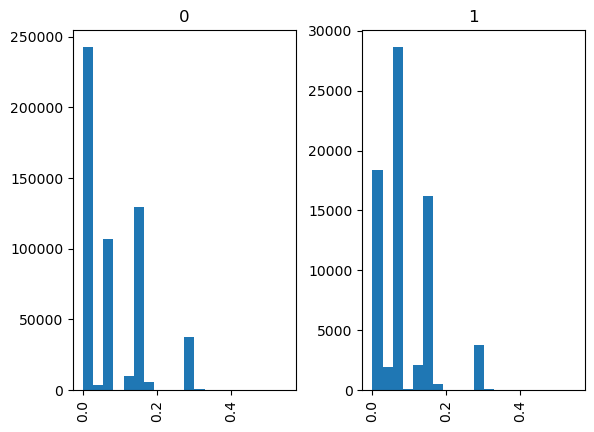

variable:  numOCS
pvalue:  0.0


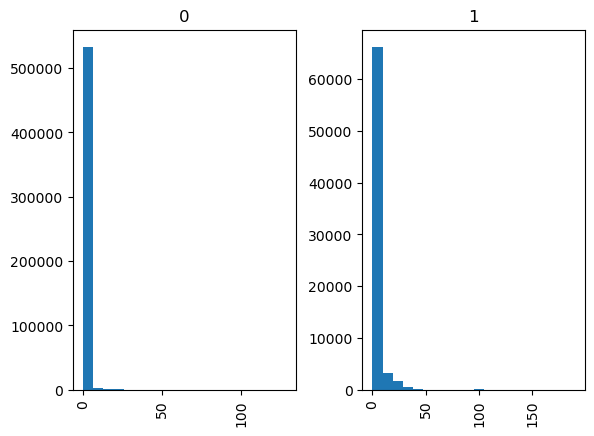

variable:  numPCS
pvalue:  0.0


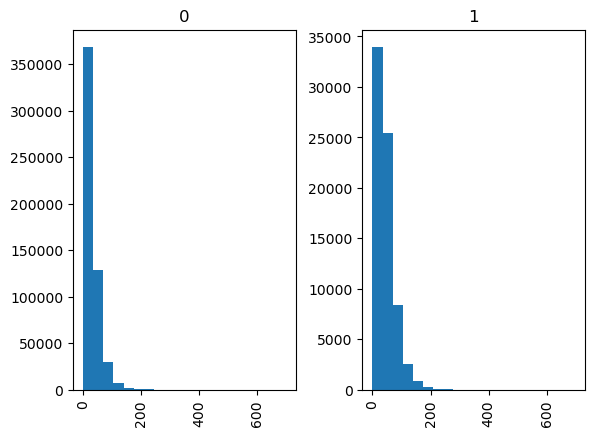

variable:  numPCSAsthma
pvalue:  0.0


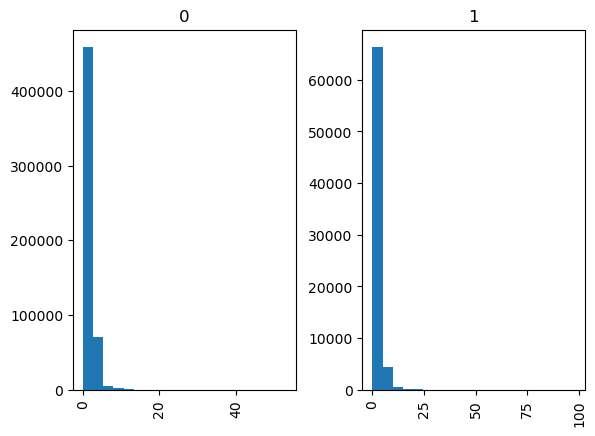

variable:  numAntibioticsEvents
pvalue:  0.0


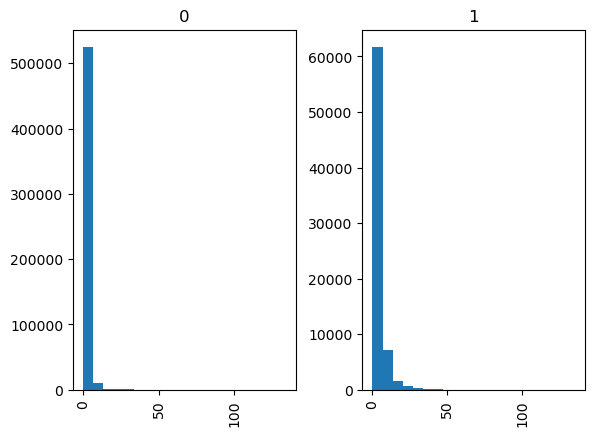

variable:  numAntibioticswithLRTI
pvalue:  0.0


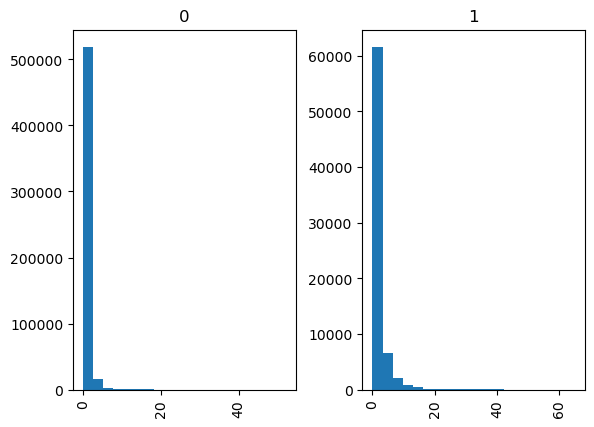

variable:  numOCSEvents
pvalue:  0.0


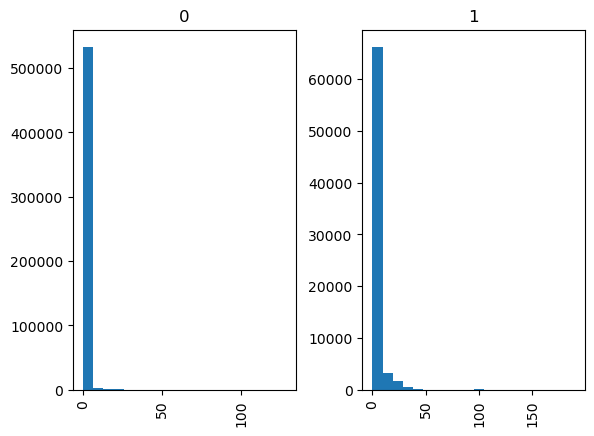

variable:  numOCSwithLRTI
pvalue:  0.0


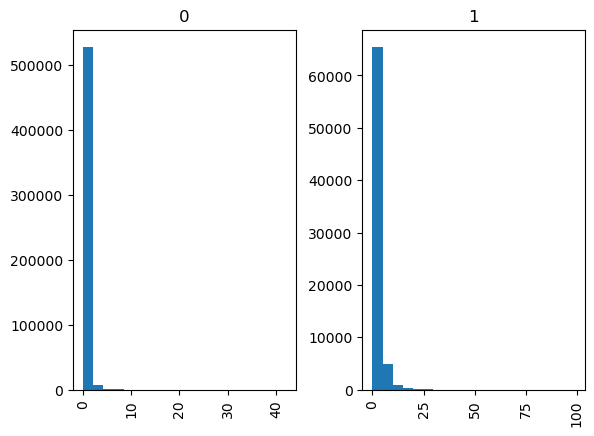

variable:  numAsthmaAttacks
pvalue:  0.0


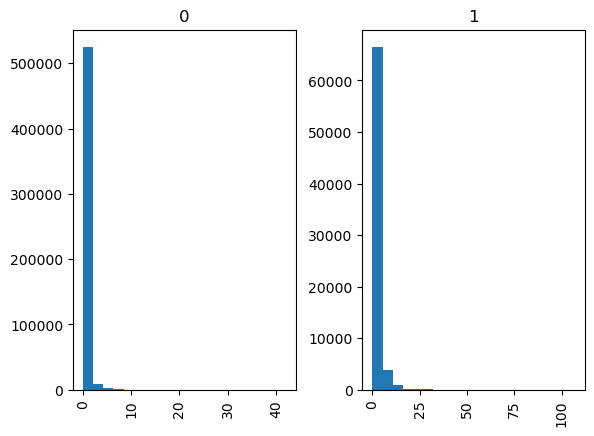

variable:  numAcuteRespEvents
pvalue:  3.4529982064221415e-214


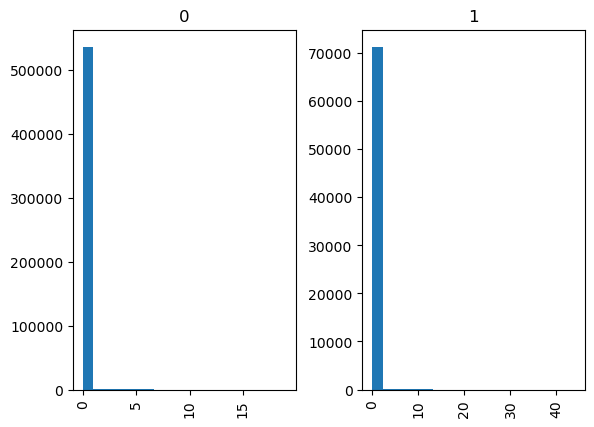

variable:  numHospEvents
pvalue:  0.0


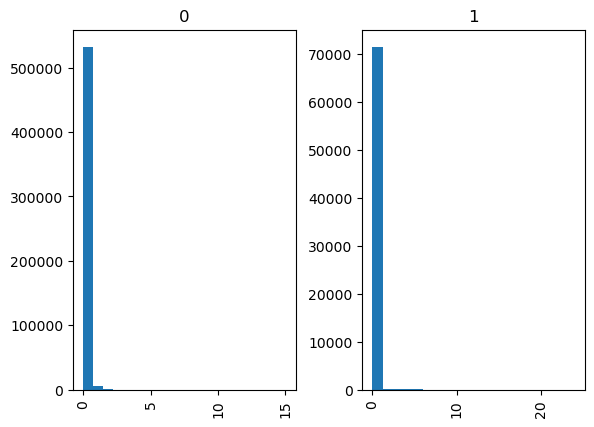

In [62]:
for var in cont_vars:
    print('variable: ', var)
    trainingData.hist(var, by=outcome, bins=20)
    print('pvalue: ', ttest_ind(trainingData[var][trainingData[outcome] == 0].values, trainingData[var][trainingData[outcome] == 1].values)[1])
    plt.show()